In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
FIG_WIDTH = 8
FIGSIZE=(FIG_WIDTH, .618 * FIG_WIDTH)

# loading images

In [2]:
video = np.load('LifeOfBrian.npy')
video = np.swapaxes(video, 0, -1)
video = np.swapaxes(video, 0, 1)
video = video[:, 10:(10+36), :64]
N_X, N_Y, N_frame = video.shape
print('video.shape=', video.shape)

video.shape= (36, 36, 64)


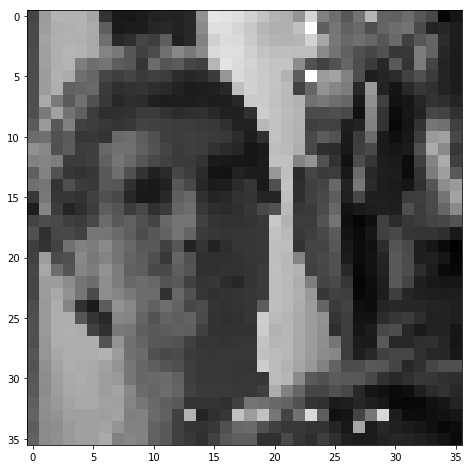

In [3]:
image = video[:, :, 34]
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image, cmap=plt.gray())

# AR(1) filtering

In [4]:
alpha = -.61803

In [5]:
%%time
video_ar = np.zeros_like(video)
for i in range(N_frame):
    video_ar[:, :, i] = video[:, :, i] + alpha *video[:, :, i-1]
    

CPU times: user 2.21 ms, sys: 702 µs, total: 2.91 ms
Wall time: 2.25 ms


In [6]:
%%time
video_ar = video + alpha * np.roll(video, 1, axis=-1)

CPU times: user 1.19 ms, sys: 29 µs, total: 1.22 ms
Wall time: 1.24 ms


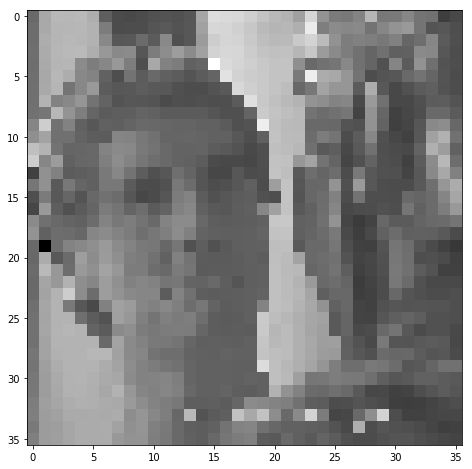

In [7]:
image = video_ar[:, :, 34]
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image, cmap=plt.gray())

# AR(2) filtering

In [8]:
alpha, beta = -.61803, .61803-1. +.5

In [9]:
%%time
video_ar = video + alpha * np.roll(video, 1, axis=-1) + beta * np.roll(video, 2, axis=-1)

CPU times: user 3.17 ms, sys: 1.46 ms, total: 4.63 ms
Wall time: 2.81 ms


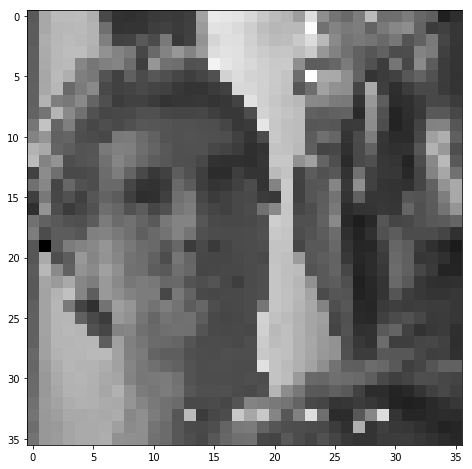

In [10]:
image = video_ar[:, :, 34]
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image, cmap=plt.gray())

# ARMA(2, 1) filtering

In [11]:
alpha, beta, gamma = -.61803, .61803-1., .5

In [12]:
%%time
video_ar = video + alpha * np.roll(video, 1, axis=-1) + beta * np.roll(video, 2, axis=-1)
for t in range(5):
    video_ar += gamma**t * np.roll(video_ar, t+1, axis=-1)

CPU times: user 3.67 ms, sys: 2.1 ms, total: 5.77 ms
Wall time: 3.4 ms


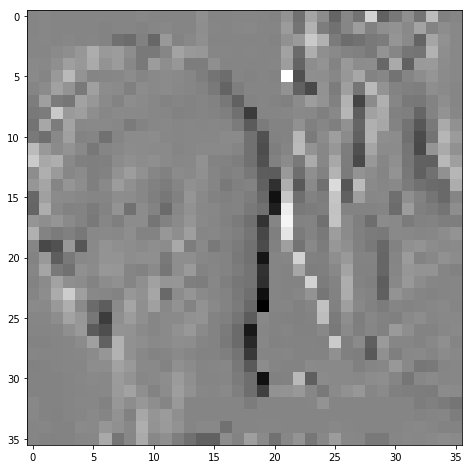

In [13]:
image = video_ar[:, :, 34]
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image, cmap=plt.gray())

In [14]:
image = video_ar[:, :, 34]
video = video_ar 

# designing filters

lg.pe.B_sf 0.4


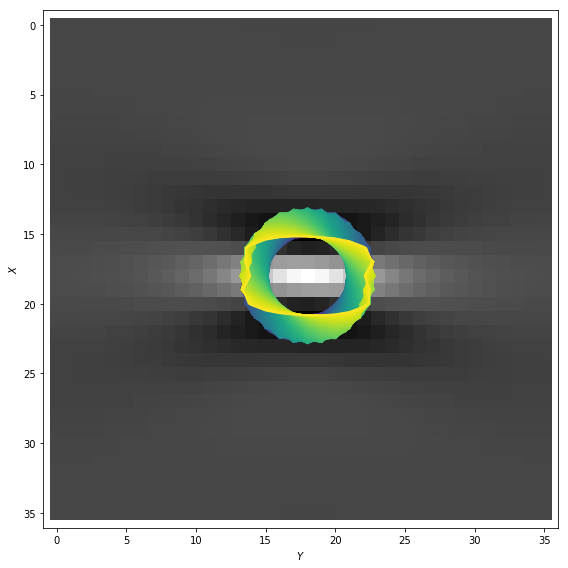

In [15]:

#from SLIP import Image, imread
from LogGabor import LogGabor
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.12, 'B_sf': .5, 'B_theta': B_theta}
print('lg.pe.B_sf', lg.pe.B_sf)

N_theta, N_phase = 180, 2
thetas = np.linspace(0, np.pi, N_theta, endpoint=False)

phi = np.zeros((N_theta, N_phase, N_X, N_Y))

for i_theta, theta in enumerate(thetas):
    x = N_X/2
    y = N_Y/2
    params.update(theta=theta)
    for i_phase in range(N_phase):
        phase = i_phase * np.pi/2
        kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
        phi[i_theta, i_phase, :] = lg.normalize(kernel)

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))

ax.imshow(phi[i_theta, 0, :], cmap=plt.gray())

for i_theta in range(N_theta):
    env = np.sqrt(phi[i_theta, 0, :]**2 + phi[i_theta, 1, :]**2)
    ax.contour(env, levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
#fig.suptitle('Tiling of visual space using phi')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
#plt.savefig('logPolar_shape.pdf')

In [16]:
lg.pe.B_theta*180/np.pi

9.99999155336135

In [17]:
lg.mask.max()

0.9986571965185531

# filtering images

In [18]:
image_ = (image*lg.mask).reshape((N_X*N_Y))
print('image_.shape', image_.shape)

image_.shape (1296,)


In [19]:
phi_ = phi.reshape((N_theta, N_phase, N_X*N_Y))
print('phi_.shape', phi_.shape)

phi_.shape (180, 2, 1296)


In [20]:
code = phi_ @ image_
print('All scalar products in one shot = ', (code).shape )

All scalar products in one shot =  (180, 2)


In [21]:
theta_bins = np.linspace(-np.pi/N_theta/2, -3*np.pi/N_theta/2+np.pi, N_theta)
print('theta_bins', theta_bins)
#binedges_theta = np.hstack((theta_bin, theta_bin[0]+np.pi))
#print('binedges_theta', binedges_theta)
width = np.pi/N_theta #binedges_theta[1:] - binedges_theta[:-1]
print('width', width)

theta_bins [-0.00872665  0.00872665  0.02617994  0.04363323  0.06108652  0.07853982
  0.09599311  0.1134464   0.13089969  0.14835299  0.16580628  0.18325957
  0.20071286  0.21816616  0.23561945  0.25307274  0.27052603  0.28797933
  0.30543262  0.32288591  0.3403392   0.3577925   0.37524579  0.39269908
  0.41015237  0.42760567  0.44505896  0.46251225  0.47996554  0.49741884
  0.51487213  0.53232542  0.54977871  0.56723201  0.5846853   0.60213859
  0.61959188  0.63704518  0.65449847  0.67195176  0.68940505  0.70685835
  0.72431164  0.74176493  0.75921822  0.77667152  0.79412481  0.8115781
  0.82903139  0.84648469  0.86393798  0.88139127  0.89884456  0.91629786
  0.93375115  0.95120444  0.96865773  0.98611103  1.00356432  1.02101761
  1.0384709   1.0559242   1.07337749  1.09083078  1.10828408  1.12573737
  1.14319066  1.16064395  1.17809725  1.19555054  1.21300383  1.23045712
  1.24791042  1.26536371  1.282817    1.30027029  1.31772359  1.33517688
  1.35263017  1.37008346  1.38753676  1.4

[]

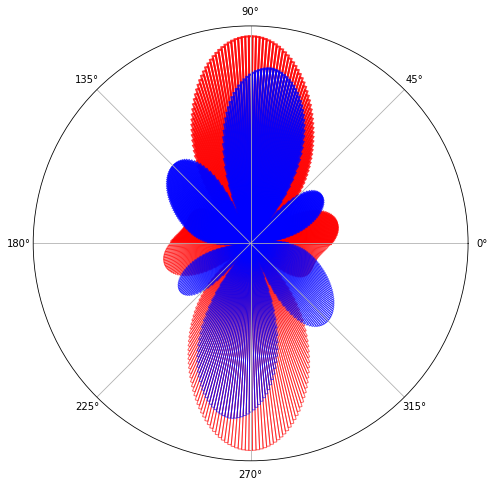

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH, FIG_WIDTH), subplot_kw=dict(projection='polar'))
for i, c in enumerate(['r', 'b']): 
    #ax.plot(theta, np.abs(code[:, i])**.5, color=c)
    #ax.plot(theta+np.pi, np.abs(code[:, i])**.5, color=c)
    # in polar coordinates, probability should be made proportional to
    # the surface, i.e. bars height to the square root of probability
    # see http://blog.invibe.net/posts/2014-12-09-polar-bar-plots.html
    ax.bar(theta_bins, (np.abs(code[:, i]))**.5, width=width, color='none', edgecolor=c, lw=2, align='edge', alpha=.8)# edgecolor="none")
    ax.bar(theta_bins+np.pi, (np.abs(code[:, i]))**.5, width=width, color='none', edgecolor=c, align='edge', alpha=.6)
    #ax.plot(theta_bin, np.ones_like(theta_bin)*np.sqrt(v_hist.mean()), 'r--')
    #ax.plot(theta_bin+np.pi, np.ones_like(theta_bin)*np.sqrt(v_hist.mean()), 'r--')
plt.setp(ax, yticks=[])

In [23]:
%%timeit
code = phi_ @ image_

309 µs ± 6.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# filtering video

In [24]:
video_ = video.reshape((N_X*N_Y, N_frame))
print('video_.shape', video_.shape)

video_.shape (1296, 64)


In [25]:
phi_ = phi.reshape((N_theta, N_phase, N_X*N_Y))
print('phi_.shape', phi_.shape)

phi_.shape (180, 2, 1296)


In [26]:
code = phi_ @ video_
print('All scalar products in one shot = ', (code).shape )

All scalar products in one shot =  (180, 2, 64)


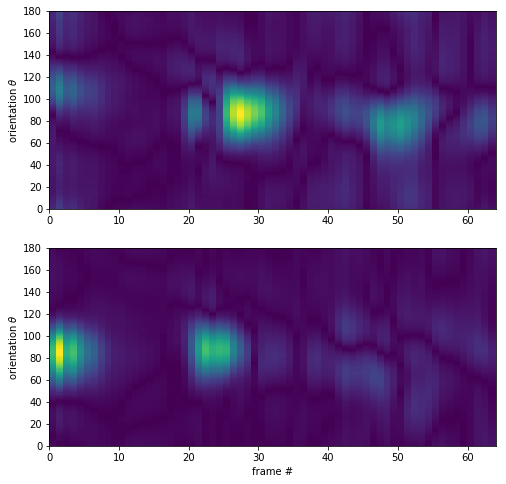

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_WIDTH))

for i in range(2): 
    axs[i].pcolormesh(np.abs(code[:, i, :]), cmap=plt.viridis())
    if i: axs[i].set_xlabel('frame #')
    axs[i].set_ylabel(r'orientation $\theta$')

In [28]:
%%timeit
code = phi_ @ video_

14 ms ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# temporal evolution

In [29]:
code2 = np.sqrt(np.sum(code**2, axis=1))
print('code2.shape', code2.shape)

code2.shape (180, 64)


Text(0, 0.5, 'orientation $\\theta$')

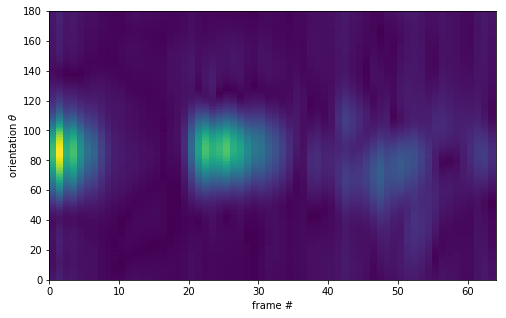

In [30]:
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

ax.pcolormesh(code2, cmap=plt.viridis())
ax.set_xlabel('frame #')
ax.set_ylabel(r'orientation $\theta$')


# temporal evolution

In [31]:
theta_mean = np.sum(code2, axis=1)
print('theta_mean.shape', theta_mean.shape)

theta_mean.shape (180,)


(0.0, 6.283185307179586, 0.0, 20.497984253833483)

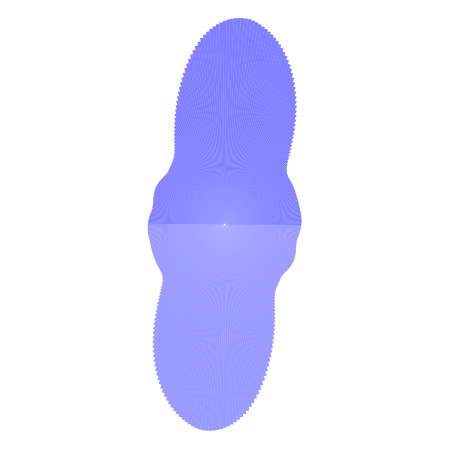

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH, FIG_WIDTH), subplot_kw=dict(projection='polar'))
ax.bar(theta_bins, (theta_mean)**.5, width=width, color=c, align='edge', alpha=.5)
ax.bar(theta_bins+np.pi, (theta_mean)**.5, width=width, color=c, align='edge', alpha=.4)
ax.set_xticks([])
ax.set_yticks([])
#ax.grid(False)
ax.axis('off')

In [33]:
code2_mean = np.mean(code2, axis=0)
print('code2_mean.shape', code2_mean.shape)

code2_mean.shape (64,)


Text(0, 0.5, 'energy in orientation $\\theta$')

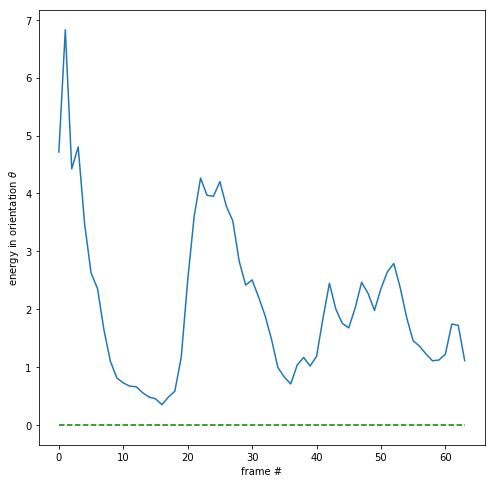

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH, FIG_WIDTH))
ax.plot(code2_mean)
ax.plot(np.zeros_like(code2_mean), 'g--')
ax.set_xlabel('frame #')
ax.set_ylabel(r'energy in orientation $\theta$')

Text(0, 0.5, 'orientation $\\theta$')

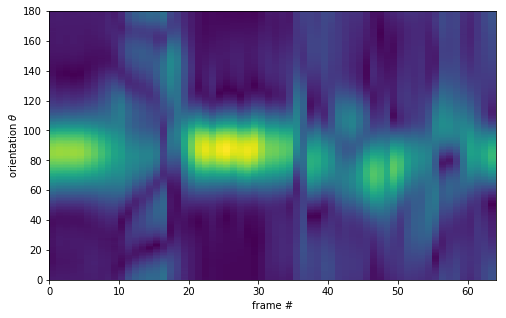

In [35]:
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

ax.pcolormesh(code2/code2_mean[None, :], cmap=plt.viridis())
ax.set_xlabel('frame #')
ax.set_ylabel(r'orientation $\theta$')


Text(0, 0.5, 'orientation $\\theta$')

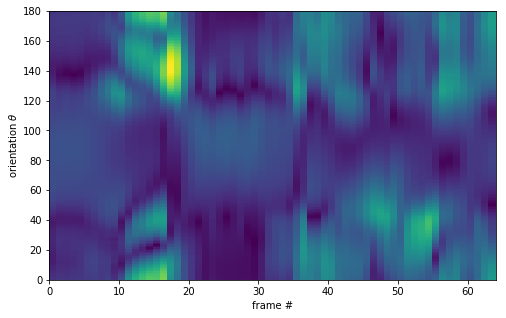

In [36]:
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

ax.pcolormesh(code2/code2_mean[None, :]/theta_mean[:, None], cmap=plt.viridis())
ax.set_xlabel('frame #')
ax.set_ylabel(r'orientation $\theta$')


# temporal evolution: animation

In [37]:
%%capture
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
#plt.rc('animation', html='html5')
import numpy as np

code2_norm = (np.abs(code2/code2_mean[None, :]/theta_mean[:, None]))**.5
fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH, FIG_WIDTH), subplot_kw=dict(projection='polar'))

N_frame_, periods = N_frame//1, 4
vmax = 1.1*np.max(code2_norm)
opts = dict(width=width, align='edge')# edgecolor="none")
topts = dict(style='italic',
        bbox={'facecolor':'white', 'edgecolor':'white', 'alpha':0.5, 'pad':10})
fps = 24 # just guessing
T = N_frame_/fps
theta_text, radius_text = -50./180.*np.pi, 1.05*vmax
def animate(i):
    #fig.suptitle(f'Frame {i}/{N_frame_}')
    ax.text(theta_text-.3, radius_text, f'Frame {i:2}/{N_frame_}', **topts)
    ax.text(theta_text, radius_text, f't={i/N_frame_*T:.3f}s', **topts)
    #fig.clear()
    #print (np.mod(periods*i/N_frame_, 1))
    c = matplotlib.colors.hsv_to_rgb((np.mod(periods*i/N_frame_, 1), 1, 1))
    #c = matplotlib.colors.hsv_to_rgb((i/N_frame_, 1, 1))
    
    ax.bar(theta_bins, vmax*np.ones_like(code2_norm[:, i]), **opts, color='w', alpha=.1)
    ax.bar(theta_bins+np.pi, vmax*np.ones_like(code2_norm[:, i]), **opts, color='w', alpha=.1)
    ax.bar(theta_bins, code2_norm[:, i], **opts, color=c, alpha=.3)
    ax.bar(theta_bins+np.pi, code2_norm[:, i], **opts, color=c, alpha=.3)
    ax.set_ylim(0, vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=N_frame_)

In [ ]:
ani

In [39]:
ani.save('figs/2018-10-24_Ring input.mp4')

In [40]:
%rm debug.log